Objectif R2 max

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set_style('whitegrid')

In [11]:
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

cf = cf[["FR"]]
ta = ta.loc[:, ta.columns.str.startswith("FR")]
tp = tp.loc[:, tp.columns.str.startswith("FR")]

In [12]:
data = pd.concat([ta.mean(axis=1).rename("TA"),
                  tp.mean(axis=1).rename("TP"),
                  cf["FR"].rename("CF")], axis=1)

In [13]:
# Features & Target
X = data.drop(columns="CF")
y = data["CF"]

#ajout d'une feunêtre
X_days_TP = X["TP"].rolling(window=7, min_periods=1).sum()
X_days_TA = X["TA"].rolling(window=60, min_periods=1).mean()
X_days_TP = X_days_TP.reset_index(drop=True)
X_days_TA = X_days_TA.reset_index(drop=True)

#ajout des saisons
cos = [np.cos(2*np.pi*(t/365)) for t in range(3285)]
sin = [np.sin(2*np.pi*(t/365)) for t in range(3285)]
Saison = pd.DataFrame([[x,y] for x, y in zip(cos,sin)], columns = [5,6])

#Création du tableau
X2 = pd.concat([X_days_TP, X_days_TA], axis = 1)

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=365, shuffle=False)

#Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.concat([X_train_std, Saison[:][:2920]], axis=1)
X_test_std = pd.concat([X_test_std, Saison[:][2920:]], axis=1)

results = {"Actual": y_test}

In [14]:
def display_result(y_true, y_pred):
    """Affiche les résultats de prédiction / réels."""
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")

    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, color="tab:blue", s=10)

    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_ylim(lb, ub)
    ax2.set_xlim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    plt.show()

In [15]:
def display_result_season(y_true, y_pred):
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : 
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()

R2: 0.433786
MSE: 0.006109



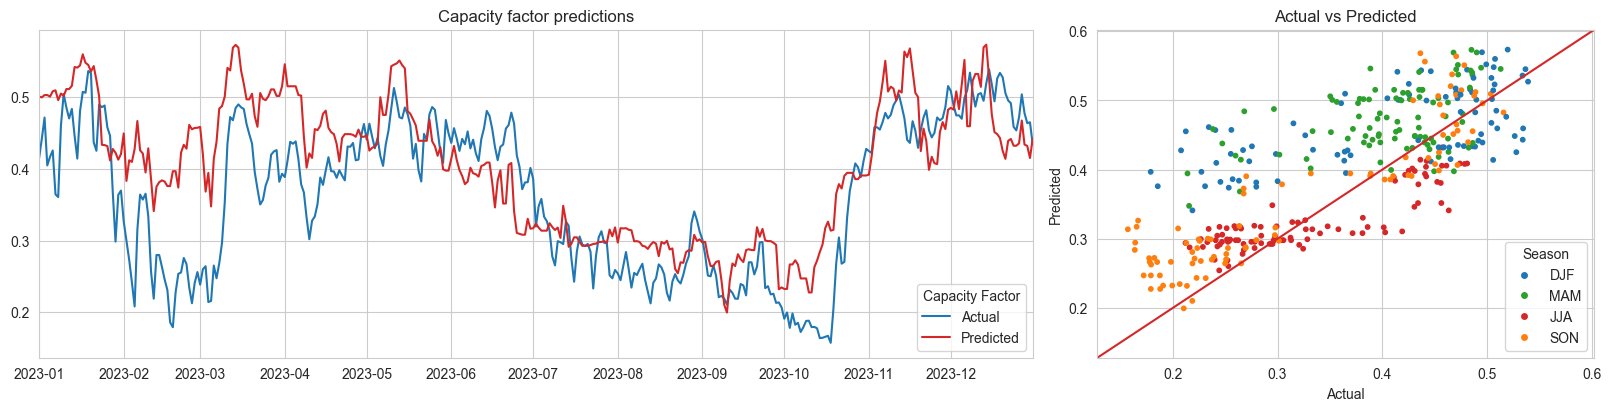

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Modèle Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=300,   # nombre d’étapes de boosting
    learning_rate=0.05, # vitesse d'apprentissage
    max_depth=3,        # profondeur des arbres faibles
    random_state=40
)

# Entraînement
gbr.fit(X_train, y_train)

# Prédictions
y_pred = gbr.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

# Ajout dans results
results["GBR"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

# Affichage personnalisé (même que ton code)
display_result_season(y_test, y_pred)

R2: 0.318761
MSE: 0.007350



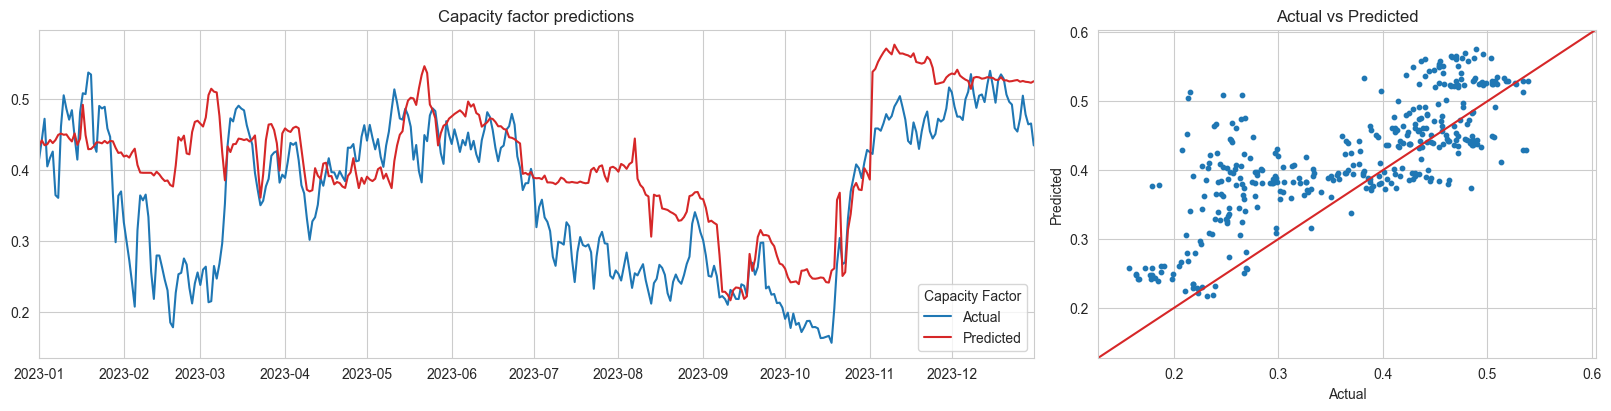

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

#données 

cf = pd.read_csv("data/CF_1d.csv", index_col = "Date", parse_dates = True)
ta = pd.read_csv("data/TA_1d.csv", index_col = "Date", parse_dates = True)
tp = pd.read_csv("data/TP_1d.csv", index_col = "Date", parse_dates = True)

cf_FR = cf[["FR"]]
ta_FR = ta[ta.columns[ta.columns.str.startswith("FR")]]
tp_FR = tp[tp.columns[tp.columns.str.startswith("FR")]]

# Features & Target
X = pd.merge(ta_FR.rolling(window=14, min_periods=1).mean(), tp_FR.rolling(window=90, min_periods=1).sum(), left_index = True, right_index = True, suffixes = ("_TA", "_TP"))
y = data["CF"]


# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std["cos"] = np.cos(X_train_std.index.dayofyear * 2 * np.pi/365)
X_train_std["sin"] = np.sin(X_train_std.index.dayofyear * 2 * np.pi/365)

results2 = {"Actual": y_test}

from sklearn.ensemble import RandomForestRegressor

# Modèle Random Forest
rf = RandomForestRegressor(
    n_estimators=300,   # nombre d'arbres
    max_depth= 10,    # profondeur illimitée
    random_state=30,
    n_jobs=-1          # utilise tous les cœurs CPU
)

# Entraînement
rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

# Ajout dans results
results2["GBR"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

Démarrage de l'entraînement (cela peut prendre un moment)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


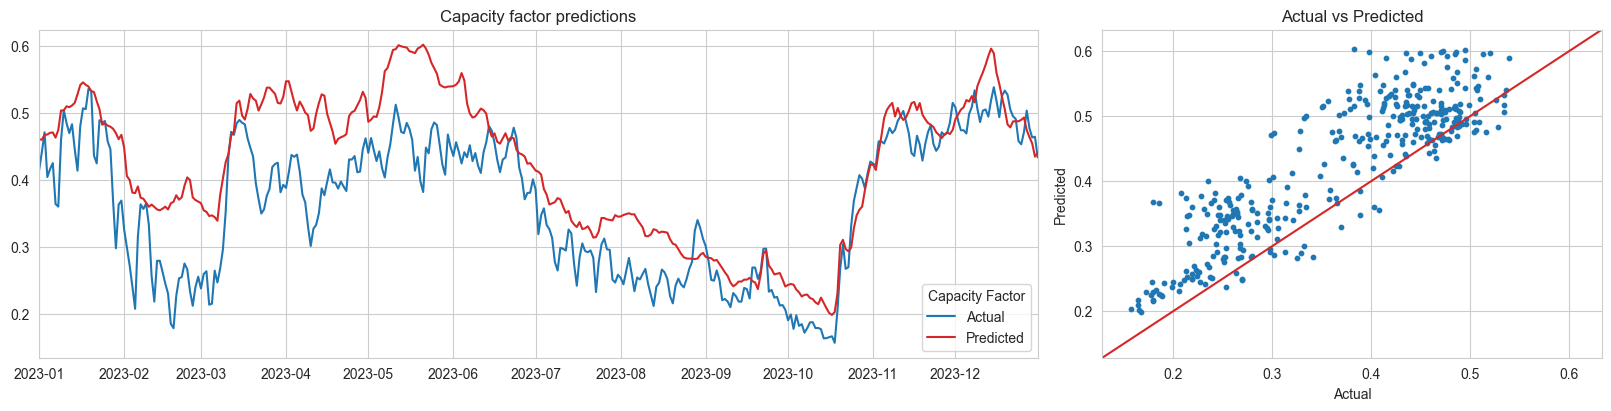

0.4244547105203186


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# --- 1. CHARGEMENT ET PRÉPARATION ---
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=True)
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=True)
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=True)

# Sélection FR uniquement
y = cf["FR"].rename("Target")
ta_fr = ta[ta.columns[ta.columns.str.startswith("FR")]].mean(axis=1).rename("TA")
tp_fr = tp[tp.columns[tp.columns.str.startswith("FR")]].mean(axis=1).rename("TP")

# Création d'un DataFrame unique pour le feature engineering
df = pd.concat([ta_fr, tp_fr, y], axis=1).dropna()

# --- 2. FEATURE ENGINEERING AVANCÉ ---

# A. Saisonnalité cyclique (Indispensable pour l'hydro)
df['sin_day'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['cos_day'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# B. Moyennes mobiles (Rolling Windows)
# Court terme (réaction rapide), Moyen terme (sols), Long terme (réservoirs/nappes)
for window in [7, 30, 90]:
    df[f'TP_roll_{window}'] = df['TP'].rolling(window=window).sum()
    df[f'TA_roll_{window}'] = df['TA'].rolling(window=window).mean()

# C. Effet "Retard" (Lags)
# La pluie d'il y a 3 jours impacte le débit d'aujourd'hui
lags = [1, 2, 7, 14]
for lag in lags:
    df[f'TP_lag_{lag}'] = df['TP'].shift(lag)
    # On peut aussi mettre des lags sur la target (Auto-régressif) si on prédit à t+1
    # df[f'Target_lag_{lag}'] = df['Target'].shift(lag) 

# D. Interaction Neige (Simplifiée)
# Si Temp < 0, la précipitation est stockée (neige), sinon elle ruisselle
df['Snow_Potential'] = df.apply(lambda row: row['TP'] if row['TA'] < 0 else 0, axis=1)
# Fonte : Si Temp > 0 après une période froide (approximation via rolling mean)
df['Melt_Potential'] = df.apply(lambda row: row['TA'] * row['TP_roll_90'] if row['TA'] > 5 else 0, axis=1)

# Nettoyage des NaN créés par le rolling/shift
df = df.dropna()

# Séparation X et y
features = [c for c in df.columns if c != "Target"]
X = df[features]
y = df["Target"]

# --- 3. SPLIT ET NORMALISATION ---
# Split temporel strict (pas de shuffle)
test_size = 365
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# Normalisation (Important même pour RF si on a des interactions complexes)
scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. MODÉLISATION ET OPTIMISATION ---

# Définition du modèle de base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Recherche d'hyperparamètres (Optimisation)
# On cherche à éviter l'overfitting tout en gardant assez de profondeur
param_dist = {
    'n_estimators': [200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] # Très important pour réduire la corrélation entre arbres
}

# TimeSeriesSplit pour valider sans tricher (ne pas prédire le passé avec le futur)
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10, # Augmente ce nombre si tu as du temps CPU (ex: 50)
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Démarrage de l'entraînement (cela peut prendre un moment)...")
random_search.fit(X_train_scaled, y_train)

best_model = random_search.best_estimator_
print(f"Meilleurs paramètres : {random_search.best_params_}")

# --- 5. ÉVALUATION ---
y_pred = best_model.predict(X_test_scaled)
y_pred_series = pd.Series(y_pred, index=y_test.index)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

display_result(y_test, y_pred)
print(r2)

Entraînement en cours...

NOUVEAU R2: 0.9235
MSE: 0.000825


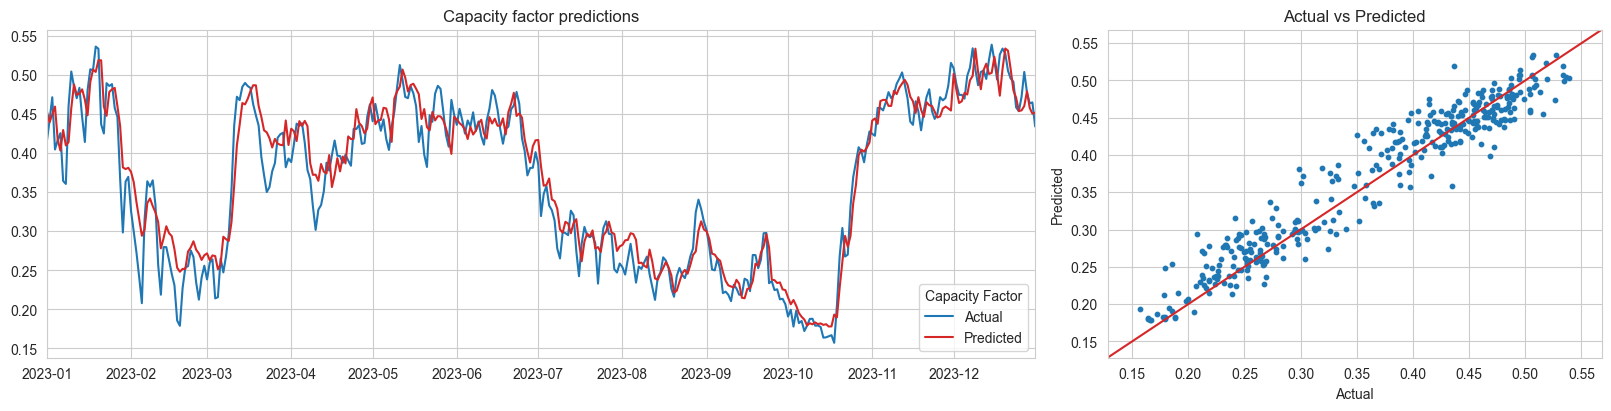

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# --- 1. CHARGEMENT ---
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=True)
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=True)
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=True)

# Focus France
y = cf["FR"].rename("CF") # Target
ta_fr = ta[ta.columns[ta.columns.str.startswith("FR")]].mean(axis=1).rename("TA")
tp_fr = tp[tp.columns[tp.columns.str.startswith("FR")]].mean(axis=1).rename("TP")

df = pd.concat([ta_fr, tp_fr, y], axis=1).sort_index()

# --- 2. PHYSIQUE & FEATURE ENGINEERING (Le secret est ici) ---

# A. Différencier Neige vs Pluie
# Si TA < 1°C, on considère que c'est de la neige (stock), sinon pluie (flux)
df['Solid_Precip'] = df.apply(lambda row: row['TP'] if row['TA'] < 1 else 0, axis=1)
df['Liquid_Precip'] = df.apply(lambda row: row['TP'] if row['TA'] >= 1 else 0, axis=1)

# B. Accumulation du manteau neigeux (Snowpack proxy)
# Somme roulante de la neige sur l'hiver (90 jours) pondérée
df['Snowpack_Est'] = df['Solid_Precip'].rolling(window=90).sum()

# C. Potentiel de Fonte (Melt)
# Si on a du Snowpack et que la température monte > 0, ça fond massivement
df['Melt_Potential'] = df['Snowpack_Est'] * np.maximum(0, df['TA'])

# D. Indice de Saturation du Sol (Soil Moisture Proxy)
# La pluie ruisselle plus si le sol est déjà gorgé d'eau (pluie des 14 derniers jours)
df['Soil_Saturation'] = df['TP'].rolling(window=14).mean()

# E. Variables Temporelles Cycliques
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# F. L'ARME FATALE : Lags de la Target (Auto-régression)
# On utilise la production d'hier pour prédire demain.
# ATTENTION : Uniquement valide si tu prédis à t+1 jour !
df['CF_Last_Day'] = df['CF'].shift(1)
df['CF_Last_Week'] = df['CF'].shift(7)
df['CF_Rolling_Mean_7d'] = df['CF'].shift(1).rolling(window=7).mean()

# G. Différences (Tendances)
# Est-ce que la température monte ou descend par rapport à hier ?
df['Delta_TA'] = df['TA'].diff()

# Nettoyage
df = df.dropna()

# --- 3. PRÉPARATION ---
features = [
    'TA', 'TP', 
    'Solid_Precip', 'Liquid_Precip', 'Snowpack_Est', 'Melt_Potential', # Physique
    'Soil_Saturation',
    'day_sin', 'day_cos', # Saison
    'CF_Last_Day', 'CF_Last_Week', 'CF_Rolling_Mean_7d', # Inertie (Crucial !)
    'Delta_TA'
]

target = 'CF'

X = df[features]
y = df[target]

# Split Chronologique (Surtout pas de shuffle)
test_days = 365
X_train, X_test = X.iloc[:-test_days], X.iloc[-test_days:]
y_train, y_test = y.iloc[:-test_days], y.iloc[-test_days:]

# --- 4. MODÈLE ROBUSTE ---

# Optimisation Random Forest pour éviter l'overfitting sur les séries temporelles
rf = RandomForestRegressor(
    n_estimators=500,       # Plus d'arbres lisse la variance
    max_depth=15,           # Limiter la profondeur évite d'apprendre le bruit
    min_samples_leaf=4,     # Force des "feuilles" plus généralistes
    max_features='sqrt',    # Force la décorrélation des arbres
    n_jobs=-1,
    random_state=42
)

print("Entraînement en cours...")
rf.fit(X_train, y_train)

# --- 5. RÉSULTATS ---
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\nNOUVEAU R2: {r2:.04f}") # On vise > 0.70
print(f"MSE: {mse:.06f}")

display_result(y_test, y_pred)
 